In [ ]:
import os
import torch
import numpy as np
from scipy.io import loadmat
import PIL
from PIL import Image

import data_loader
import models
from utils.metrics import EncodeColor

import pydensecrf.densecrf as dcrf

colors = loadmat('data_loader/mit_scene_color150.mat')

def test(config):
  device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

  # Setup dataloader
  mit_data = data_loader.get_loader("mit_sceneparsing_benchmark")
  mit_data = mit_data("validation")

  # Load model checkpoint
  model = models.FCN32s(mit_data.n_classes).to(device)
  print(f"Loading model checkpoint: {config['ckpoint']}")
  ckpoint = torch.load(config["ckpoint"], map_location=device)
  model.load_state_dict(ckpoint["model_state"])
  print(f"Saved epoch: {ckpoint['epoch']}, loss: {ckpoint['epoch_loss']}, time: {ckpoint['epoch_time']}")
  model.eval()
  model.to(device)
  for img, img_path in mit_data.get_images():
    img = img.to(device)
    # Make this into a batch of size 1. Model neeed NCHW
    img = img.unsqueeze(0) # [1, C=3, H=512, W=512]
    out = model(img) # [1, C=151, H=512, W=512]
    
    # Run the model softmax output through a densecrf
    # AH TODO
    
    _, pred = out.max(1) # [1, H=512, W=512]
    pred_np = pred.squeeze().cpu().numpy() # [H=512, W=512]
    print(pred_np)
    pred_col = EncodeColor(pred_np, colors['colors'])
    
    orig_file_name = os.path.splitext(os.path.basename(img_path))[0]
    results_file = "results/" + orig_file_name + "_res.png"
    Image.fromarray(pred_col).save(results_file)

    
config = {"ckpoint": "checkpoints/mit_sceneparsing_FCN32s_full_logs_2.pkl"}
test(config)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Generating 10000 images
Loading model checkpoint: checkpoints/mnist_SmallAutoEncoder_denoise_logs_0.pkl
Saved epoch: 498, loss: 16.759808354079723, time: 3.943406581878662
653
654
655


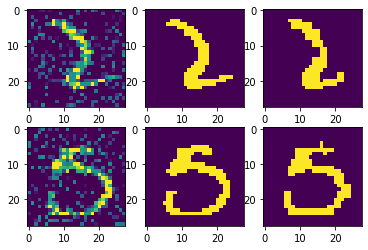

In [42]:
%load_ext autoreload
%autoreload 2

import os
import torch
import numpy as np

import data_loader
import models
from utils.metrics import EncodeColor
# Datasets
from data_loader.mnist import NoisyMNISTDataLoader
# Models
from models.autoencoder import SmallAutoEncoder

from matplotlib.pyplot import imshow
from IPython import display
import matplotlib.pyplot as plt
import random

def test(config):
  device = torch.device("cpu")#"cuda" if torch.cuda.is_available() else "cpu")

  # Setup dataloader
  noisy_mnist = NoisyMNISTDataLoader("validation")
    
  # Load model checkpoint
  model = SmallAutoEncoder().to(device)
  print(f"Loading model checkpoint: {config['ckpoint']}")
  ckpoint = torch.load(config["ckpoint"], map_location=device)
  model.load_state_dict(ckpoint["model_state"])
  print(f"Saved epoch: {ckpoint['epoch']}, loss: {ckpoint['epoch_loss']}, time: {ckpoint['epoch_time']}")
  model.eval()
  model.to(device)
  
  n_imgs = 2
  f, axarr = plt.subplots(n_imgs,3)

  start_idx = random.randint(0,len(noisy_mnist))
  
  ctr = 0
  for idx in range(start_idx, len(noisy_mnist)):
    img, label = noisy_mnist[idx]
    if ctr >= n_imgs:
      break
    img = img.to(device)
    # Make this into a batch of size 1. Model neeed NCHW
    img = img.unsqueeze(0) # [1, C=1, H=28, W=28]
    out = model(img) # [1, C=2, H=28, W=28]
    
    _, pred = out.max(1) # [1, H=28, W=28]
    pred_np = pred.squeeze().cpu().numpy() # [H=512, W=512]
    
    axarr[ctr,0].imshow(img.squeeze())
    axarr[ctr,1].imshow(label)
    axarr[ctr,2].imshow(pred_np)
    ctr+=1
        
config = {"ckpoint": "checkpoints/mnist_SmallAutoEncoder_denoise_logs_0.pkl"}
test(config)